In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

In [7]:
# parameters 
N = 180 # number of I & E neurons
xs = np.linspace(1, 180, N) # angle positions in deg

tau_E = 20 #ms
tau_I = 10 #ms

J_EE = 0.044 
J_IE = 0.042
J_EI = 0.023
J_II = 0.018

sigma_ori = 32
sigma_FF = 30
phi = 35 # stimulus grating angle, paper uses Stimulus 1 = 35deg, Stimulus 2 = 135deg

k = 0.04
n = 2.0

c = 50 # stimulus strength

 - $G_\sigma(x,y) = \exp\{-d(x,y)^2/\sigma^2\}$, where $d(x,y)=|x-y|$ for positions, and for orientations, $d(x,y) = $ shortest distance around circle with $180^\circ$ circumference between $x$ and $y$
 - $N$ excitatory units and $N$ inhibitory units
 - Stimulus grating with orientation $\phi$ is $h(\theta) = G_{\sigma_{\text{FF}}}(\phi, \theta)$
 - Connection functions are $W_{ab} = J_{ab} G_{\sigma_{\text{ori}}}(\theta, \theta')$ for $a,b \in \{E, I\}.$
 
 We implement the Euler method for solving this system.
 
 \begin{align*}
     r_E^{m+1}(x) &= r_E^m(x) + \Delta t \frac{1}{\tau_E}\left(-r_E^m(x) + F_E^m(x) \right) \\
     r_I^{m+1}(x) &= r_I^m(x) + \Delta t \frac{1}{\tau_I}\left(-r_I^m(x) + F_I^m(x) \right)
 \end{align*}
 where 
 \begin{align*}
     F_E^m(x) &= k\left(\left[ch(x) +  \sum_{y}(J_{EE}G_{\sigma_{\text{ori}}}(x,y)r_E^m(y) + J_{EI}G_{\sigma_{\text{ori}}}(x,y)r_I^m(y)) \right]_+  \right)^n \\
     F_I^m(x) &= k\left(\left[ch(x) +  \sum_{y}(J_{IE}G_{\sigma_{\text{ori}}}(x,y)r_E^m(y) + J_{II}G_{\sigma_{\text{ori}}}(x,y)r_I^m(y)) \right]_+ \right)^n
 \end{align*}
 
 with the sums running over all orientations $y$.

In [8]:
def G(x, y, sigma): # Gaussian function centered at y
    return np.exp(-np.power(x - y, 2.) / (2 * np.power(sigma, 2.)))

def h(phi, theta, sigma_FF): # stimulus of orientation phi
    return G(phi, theta, sigma_FF)

def F(x, n_type): # activation function, depends on neuron type n_type = I, E
    if n_type=='E':
        sumlst = [J_EE*G(x,y,sigma_ori)*r_E[m,y] + J_EI*G(x,y,sigma_ori)*r_I[m,y] for y in range(N)]
        ret = k*(np.max(c*h(phi,x,sigma_FF)+np.sum(sumlst), 0))**n
    elif n_type=='I':
        sumlst = [J_IE*G(x,y,sigma_ori)*r_E[m,y] + J_II*G(x,y,sigma_ori)*r_I[m,y] for y in range(N)]
        ret = k*(np.max(c*h(phi,x,sigma_FF)+np.sum(sumlst), 0))**n
    return ret

Idea:
 - $r_E = (r_E^m(x))_{\text{steps} \times N}$ is a (steps)$\times N$ matrix whose entry at the $m$-th row, $x$-th column corresponds to the $m$-th timestep calculuation of rate $r_E(x)$ of the E neuron at position $x$
 - $r_I = (r_I^m(x))_{\text{steps} \times N}$ is a (steps)$\times N$ matrix whose entry at the $m$-th row, $x$-th column corresponds to the $m$-th timestep calculuation of rate $r_I(x)$ of the I neuron at position $x$.

In [9]:
T = 2.3 # terminal time
t0 = 0  # initial time
steps = 50 # number of steps to calculate
dt = (T-t0)/steps # time change 

r_E = np.zeros((steps+1, N))
r_I = np.zeros((steps+1, N))

for m in range(steps):
    for x in range(len(xs)):
        r_E[m+1, x] = r_E[m, x] + dt*(1/tau_E)*(-r_E[m,x] + F(x, 'E'))
        r_I[m+1, x] = r_I[m, x] + dt*(1/tau_I)*(-r_I[m,x] + F(x, 'I'))

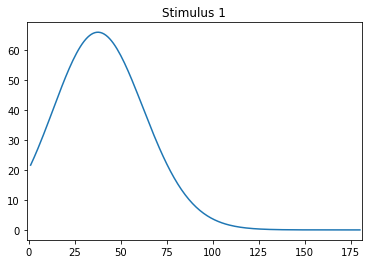

In [10]:
plt.plot(xs, r_E[-1,:])
plt.title('Stimulus 1')
plt.xlim(-1,181)
plt.show()